<a href="https://colab.research.google.com/github/kevinscaria/InstructABSA/blob/main/JointTask_Training_%26_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

@inproceedings{Scaria2023InstructABSAIL,
  title={InstructABSA: Instruction Learning for Aspect Based Sentiment Analysis},
  author={Kevin Scaria and Himanshu Gupta and Saurabh Arjun Sawant and Swaroop Mishra and Chitta Baral},
  year={2023}
}

## Libraries

In [1]:
try:
    import google.colab
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    IN_COLAB = True
except:
    IN_COLAB = False

In [2]:
if IN_COLAB:
  !pip install transformers
  !pip install datasets
  !pip install evaluate
  !pip install sentencepiece

In [3]:
import os
import torch

if IN_COLAB:
    root_path = 'Enter drive path'
else:
    root_path = r'C:\Users\rwynn\PycharmProjects\InstructABSA'
    
use_mps = True if torch.has_mps else False
os.chdir(root_path)

C:\Users\rwynn\AppData\Local\Temp\ipykernel_12008\2756787886.py:9: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  use_mps = True if torch.has_mps else False


In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

from InstructABSA.data_prep import DatasetLoader
from InstructABSA.utils import T5Generator, T5Classifier
from instructions import InstructionsHandler

## Training

In [9]:
task_name = 'joint_task'
experiment_name = 'robs_experiment'
model_checkpoint = 'kevinscaria/joint_tk-instruct-base-def-pos-neg-neut-combined' # originally set to 'allenai/tk-instruct-base-def-pos'
print('Experiment Name: ', experiment_name)
model_out_path = '.\Models'
model_out_path = os.path.join(model_out_path, task_name, f"{model_checkpoint.replace('/', '')}-{experiment_name}")
print('Model output path: ', model_out_path)

Experiment Name:  robs_experiment
Model output path:  .\Models\joint_task\kevinscariajoint_tk-instruct-base-def-pos-neg-neut-combined-robs_experiment


In [10]:
# Load the data
id_train_file_path = './Dataset/SemEval14/Train/mt_train_data.csv'
id_test_file_path = './Dataset/SemEval14/Test/mt_test_data.csv'
id_tr_df = pd.read_csv(id_train_file_path)
id_te_df = pd.read_csv(id_test_file_path)

# Get the input text into the required format using Instructions
instruct_handler = InstructionsHandler()

# Set instruction_set1 for InstructABSA-1 and instruction_set2 for InstructABSA-2
instruct_handler.load_instruction_set2()

# Set bos_instruct1 for lapt14 and bos_instruct2 for rest14. For other datasets, modify the insructions.py file.
# Have to change 'joint' to 'aspe' in code below, and use 'bos_instruct2'
loader = DatasetLoader(id_tr_df, id_te_df)
if loader.train_df_id is not None:
    loader.train_df_id = loader.create_data_in_aspe_format(loader.train_df_id, 'term', 'polarity', 'raw_text', 'aspectTerms', instruct_handler.aspe['bos_instruct2'], instruct_handler.aspe['eos_instruct'])
if loader.test_df_id is not None:
    loader.test_df_id = loader.create_data_in_aspe_format(loader.test_df_id, 'term', 'polarity', 'raw_text', 'aspectTerms', instruct_handler.aspe['bos_instruct2'], instruct_handler.aspe['eos_instruct'])

In [11]:
id_tr_df.head()

,raw_text,aspectTerms
0,I don't live in the area and was visiting from...,"[{'term': 'outside eating areas', 'polarity': ..."
1,Love this place! Come every few weeks to cozy ...,"[{'term': 'fire', 'polarity': 'positive'}, {'t..."
2,Friendly staff,"[{'term': 'staff', 'polarity': 'positive'}]"
3,I don't think the aftertaste of Mad Tree's bee...,"[{'term': 'beers', 'polarity': 'negative'}]"
4,"Had the pizza, not very happy with quality to ...","[{'term': 'pizza', 'polarity': 'negative'}]"


In [12]:
# Create T5 utils object
t5_exp = T5Generator(model_checkpoint)

# Tokenize Dataset
id_ds, id_tokenized_ds, ood_ds, ood_tokenized_ds = loader.set_data_for_training_semeval(t5_exp.tokenize_function_inputs)

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

Map:   0%|          | 0/254 [00:00<?, ? examples/s]

In [13]:
# Training arguments
training_args = {
    'output_dir':model_out_path,
    'evaluation_strategy':"epoch",
    'learning_rate':5e-5,
    'lr_scheduler_type':'cosine',
    'per_device_train_batch_size':8,
    'per_device_eval_batch_size':16,
    'num_train_epochs':4,
    'weight_decay':0.01,
    'warmup_ratio':0.1,
    'save_strategy':'no',
    'load_best_model_at_end':False,
    'push_to_hub':False,
    'eval_accumulation_steps':1,
    'predict_with_generate':True,
    'use_mps_device':use_mps,
}

In [14]:
id_tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['raw_text', 'aspectTerms', 'labels', 'text', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 590
    })
    test: Dataset({
        features: ['raw_text', 'aspectTerms', 'labels', 'text', 'input_ids', 'attention_mask'],
        num_rows: 254
    })
})

### It'll giving us an error if we don't have a validation set (when we try to train). Let's create one now.

In [15]:
# Split the test dataset in half
train_test_split = id_tokenized_ds['test'].train_test_split(test_size=0.5)
train_test_split

DatasetDict({
    train: Dataset({
        features: ['raw_text', 'aspectTerms', 'labels', 'text', 'input_ids', 'attention_mask'],
        num_rows: 127
    })
    test: Dataset({
        features: ['raw_text', 'aspectTerms', 'labels', 'text', 'input_ids', 'attention_mask'],
        num_rows: 127
    })
})

In [16]:
# Add the "new" 'train' and 'test' splits to the original DatasetDict with their new names
id_tokenized_ds['test'] = train_test_split['train']
id_tokenized_ds['validation'] = train_test_split['test']  # Use 'test' as the validation set
id_tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['raw_text', 'aspectTerms', 'labels', 'text', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 590
    })
    test: Dataset({
        features: ['raw_text', 'aspectTerms', 'labels', 'text', 'input_ids', 'attention_mask'],
        num_rows: 127
    })
    validation: Dataset({
        features: ['raw_text', 'aspectTerms', 'labels', 'text', 'input_ids', 'attention_mask'],
        num_rows: 127
    })
})

In [17]:
!python -m pip install --upgrade pip
!python -m pip install -U accelerate
!python -m pip install -U transformers

In [18]:
# Train model
model_trainer = t5_exp.train(id_tokenized_ds, **training_args)

# Training Loss says "No log" because default logging_steps in TrainingArguments is set to 500 steps, so no loss is reported before 500 steps
# see https://github.com/huggingface/transformers/issues/8910
# I tested it using logging_steps = 1 and Training Loss appeared, so it appears to work

Trainer device: cpu

Model training started ....


Epoch,Training Loss,Validation Loss
1,No log,0.295548
2,No log,0.298757
3,No log,0.296215
4,No log,0.297633


## Inference

In [ ]:
# Load the data
id_train_file_path = './Dataset/SemEval14/Train/Laptops_Train.csv'
id_test_file_path = './Dataset/SemEval14/Test/Laptops_Test.csv'
id_tr_df = pd.read_csv(id_train_file_path)
id_te_df = pd.read_csv(id_test_file_path)

# Get the input text into the required format using Instructions
instruct_handler = InstructionsHandler()

# Set instruction_set1 for InstructABSA-1 and instruction_set2 for InstructABSA-2
instruct_handler.load_instruction_set1()

# Set bos_instruct1 for lapt14 and bos_instruct2 for rest14. For other datasets, modify the insructions.py file.
# Have to change 'joint' to 'aspe' in code below, and use 'bos_instruct2'
loader = DatasetLoader(id_tr_df, id_te_df)
if loader.train_df_id is not None:
    loader.train_df_id = loader.create_data_in_joint_task_format(loader.train_df_id, 'term', 'polarity', 'raw_text', 'aspectTerms', instruct_handler.joint['bos_instruct1'], instruct_handler.joint['eos_instruct'])
if loader.test_df_id is not None:
    loader.test_df_id = loader.create_data_in_joint_task_format(loader.test_df_id, 'term', 'polarity', 'raw_text', 'aspectTerms', instruct_handler.joint['bos_instruct1'], instruct_handler.joint['eos_instruct'])

In [ ]:
# Model inference - Loading from Checkpoint
t5_exp = T5Generator(model_out_path)

# Tokenize Datasets
id_ds, id_tokenized_ds, ood_ds, ood_tokenzed_ds = loader.set_data_for_training_semeval(t5_exp.tokenize_function_inputs)

# Get prediction labels - Training set   
id_tr_pred_labels = t5_exp.get_labels(tokenized_dataset = id_tokenized_ds, sample_set = 'train', batch_size = 16)
id_tr_labels = [i.strip() for i in id_ds['train']['labels']]

# Get prediction labels - Testing set
id_te_pred_labels = t5_exp.get_labels(tokenized_dataset = id_tokenized_ds, sample_set = 'test', batch_size = 16)
id_te_labels = [i.strip() for i in id_ds['test']['labels']]

In [ ]:
p, r, f1, _ = t5_exp.get_metrics(id_tr_labels, id_tr_pred_labels)
print('Train Precision: ', p)
print('Train Recall: ', r)
print('Train F1: ', f1)

p, r, f1, _ = t5_exp.get_metrics(id_te_labels, id_te_pred_labels)
print('Test Precision: ', p)
print('Test Recall: ', r)
print('Test F1: ', f1)

## Let's evaluate the basic model on our test data

In [6]:
# Load the MT data
id_train_file_path = './Dataset/SemEval14/Train/mt_train_data.csv'
id_test_file_path = './Dataset/SemEval14/Test/mt_test_data.csv'
id_tr_df = pd.read_csv(id_train_file_path)
id_te_df = pd.read_csv(id_test_file_path)

# Get the input text into the required format using Instructions
instruct_handler = InstructionsHandler()

# Set instruction_set1 for InstructABSA-1 and instruction_set2 for InstructABSA-2
instruct_handler.load_instruction_set2()

# Set bos_instruct1 for lapt14 and bos_instruct2 for rest14. For other datasets, modify the insructions.py file.
# Have to change 'joint' to 'aspe' in code below, and use 'bos_instruct2'
loader = DatasetLoader(id_tr_df, id_te_df)
if loader.train_df_id is not None:
    loader.train_df_id = loader.create_data_in_aspe_format(loader.train_df_id, 'term', 'polarity', 'raw_text', 'aspectTerms', instruct_handler.aspe['bos_instruct2'], instruct_handler.aspe['eos_instruct'])
if loader.test_df_id is not None:
    loader.test_df_id = loader.create_data_in_aspe_format(loader.test_df_id, 'term', 'polarity', 'raw_text', 'aspectTerms', instruct_handler.aspe['bos_instruct2'], instruct_handler.aspe['eos_instruct'])

In [7]:
# Model inference - Loading from Checkpoint
t5_exp = T5Generator('kevinscaria/joint_tk-instruct-base-def-pos-neg-neut-combined')

# Tokenize Datasets
id_ds, id_tokenized_ds, ood_ds, ood_tokenzed_ds = loader.set_data_for_training_semeval(t5_exp.tokenize_function_inputs)

# Get prediction labels - Training set   
id_tr_pred_labels = t5_exp.get_labels(tokenized_dataset = id_tokenized_ds, sample_set = 'train', batch_size = 16)
id_tr_labels = [i.strip() for i in id_ds['train']['labels']]

# Get prediction labels - Testing set
id_te_pred_labels = t5_exp.get_labels(tokenized_dataset = id_tokenized_ds, sample_set = 'test', batch_size = 16)
id_te_labels = [i.strip() for i in id_ds['test']['labels']]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

Map:   0%|          | 0/127 [00:00<?, ? examples/s]

Model loaded to:  cpu


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [09:31<00:00, 15.46s/it]


Model loaded to:  cpu


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:14<00:00, 16.78s/it]


In [8]:
p, r, f1, _ = t5_exp.get_metrics(id_tr_labels, id_tr_pred_labels)
print('Train Precision: ', p)
print('Train Recall: ', r)
print('Train F1: ', f1)

p, r, f1, _ = t5_exp.get_metrics(id_te_labels, id_te_pred_labels)
print('Test Precision: ', p)
print('Test Recall: ', r)
print('Test F1: ', f1)

Train Precision:  0.7053320860617399
Train Recall:  0.7717502558853634
Train F1:  0.7370478983382209
Test Precision:  0.680161943319838
Test Recall:  0.7962085308056872
Test F1:  0.7336244541484715


### Here are the results:
Train Precision:  0.7053320860617399

Train Recall:  0.7717502558853634

Train F1:  0.7370478983382209

Test Precision:  0.680161943319838

Test Recall:  0.7962085308056872

Test F1:  0.7336244541484715

## Now let's load the model from our trained checkpoint and see the difference in how it performs on the same train/test data

In [20]:
# Model inference - Loading from Checkpoint
t5_exp = T5Generator(model_out_path)

# Tokenize Datasets
id_ds, id_tokenized_ds, ood_ds, ood_tokenzed_ds = loader.set_data_for_training_semeval(t5_exp.tokenize_function_inputs)

# Get prediction labels - Training set   
id_tr_pred_labels = t5_exp.get_labels(tokenized_dataset = id_tokenized_ds, sample_set = 'train', batch_size = 16)
id_tr_labels = [i.strip() for i in id_ds['train']['labels']]

# Get prediction labels - Testing set
id_te_pred_labels = t5_exp.get_labels(tokenized_dataset = id_tokenized_ds, sample_set = 'test', batch_size = 16)
id_te_labels = [i.strip() for i in id_ds['test']['labels']]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

Map:   0%|          | 0/254 [00:00<?, ? examples/s]

Model loaded to:  cpu


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [09:22<00:00, 15.20s/it]


Model loaded to:  cpu


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [04:40<00:00, 17.51s/it]


In [21]:
p, r, f1, _ = t5_exp.get_metrics(id_tr_labels, id_tr_pred_labels)
print('Train Precision: ', p)
print('Train Recall: ', r)
print('Train F1: ', f1)

p, r, f1, _ = t5_exp.get_metrics(id_te_labels, id_te_pred_labels)
print('Test Precision: ', p)
print('Test Recall: ', r)
print('Test F1: ', f1)

Train Precision:  0.888125613346418
Train Recall:  0.9263050153531218
Train F1:  0.906813627254509
Test Precision:  0.7851063829787234
Test Recall:  0.8661971830985915
Test F1:  0.8236607142857143


### Here are the results:
Train Precision:  0.888125613346418

Train Recall:  0.9263050153531218

Train F1:  0.906813627254509

Test Precision:  0.7851063829787234

Test Recall:  0.8661971830985915

Test F1:  0.8236607142857143

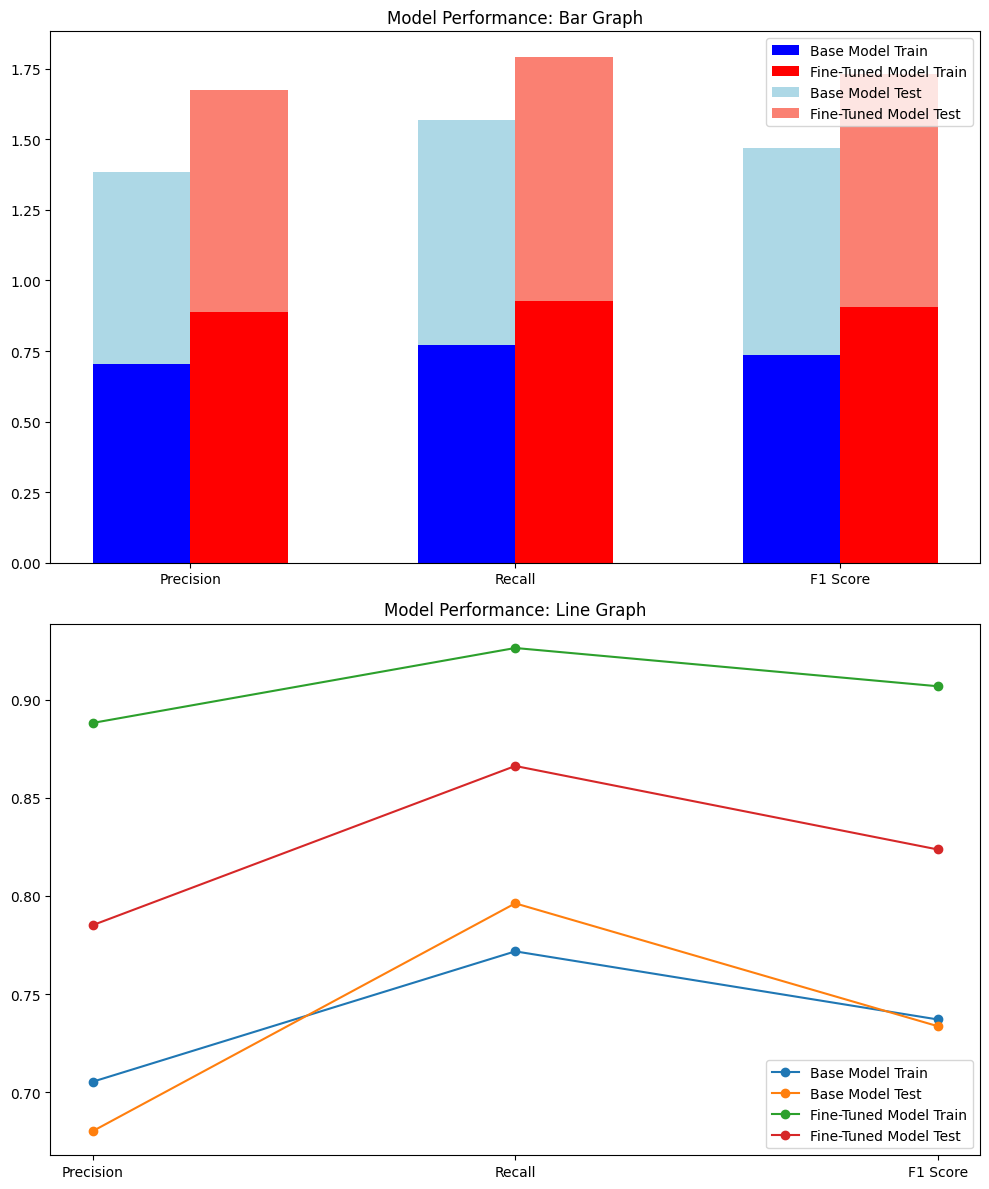

In [3]:
## Code from Chatgpt

import matplotlib.pyplot as plt

# Data for plotting
metrics = ['Precision', 'Recall', 'F1 Score']
train_base = [0.7053320860617399, 0.7717502558853634, 0.7370478983382209]
test_base = [0.680161943319838, 0.7962085308056872, 0.7336244541484715]
train_finetuned = [0.888125613346418, 0.9263050153531218, 0.906813627254509]
test_finetuned = [0.7851063829787234, 0.8661971830985915, 0.8236607142857143]

fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Bar Graph
ax[0].bar([x - 0.15 for x in range(len(metrics))], train_base, width=0.3, label='Base Model Train', color='b')
ax[0].bar([x + 0.15 for x in range(len(metrics))], train_finetuned, width=0.3, label='Fine-Tuned Model Train', color='r')
ax[0].bar([x - 0.15 for x in range(len(metrics))], test_base, width=0.3, bottom=train_base, label='Base Model Test', color='lightblue')
ax[0].bar([x + 0.15 for x in range(len(metrics))], test_finetuned, width=0.3, bottom=train_finetuned, label='Fine-Tuned Model Test', color='salmon')
ax[0].set_xticks(range(len(metrics)))
ax[0].set_xticklabels(metrics)
ax[0].set_title('Model Performance: Bar Graph')
ax[0].legend()

# Line Graph
ax[1].plot(metrics, train_base, marker='o', label='Base Model Train')
ax[1].plot(metrics, test_base, marker='o', label='Base Model Test')
ax[1].plot(metrics, train_finetuned, marker='o', label='Fine-Tuned Model Train')
ax[1].plot(metrics, test_finetuned, marker='o', label='Fine-Tuned Model Test')
ax[1].set_title('Model Performance: Line Graph')
ax[1].legend()

plt.tight_layout()
plt.show()


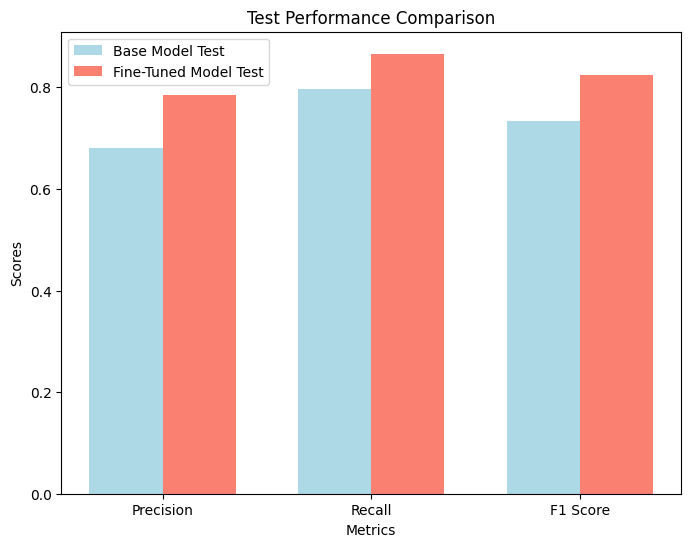

In [5]:
## bar graph just using test data

# Updated data for plotting - only test results
test_base = [0.680161943319838, 0.7962085308056872, 0.7336244541484715]
test_finetuned = [0.7851063829787234, 0.8661971830985915, 0.8236607142857143]

# Create the bar graph with the test results placed side by side
fig, ax = plt.subplots(figsize=(8, 6))

# Bar positions
bar_width = 0.35
index = range(len(metrics))

# Bars
bars1 = ax.bar(index, test_base, bar_width, label='Base Model Test', color='lightblue')
bars2 = ax.bar([p + bar_width for p in index], test_finetuned, bar_width, label='Fine-Tuned Model Test', color='salmon')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Test Performance Comparison')
ax.set_xticks([p + bar_width / 2 for p in index])
ax.set_xticklabels(metrics)
ax.legend()

plt.show()
